In [1]:
import numpy as np
import flopy as fp
import matplotlib.pyplot as plt
%matplotlib inline
import os
from matplotlib.backends.backend_pdf import PdfPages

flopy is installed in /Users/mnfienen/anaconda3/envs/pyclass/lib/python3.7/site-packages/flopy


In [2]:
model_dir = 'theis_flopy_mf6'
model_name = 'theis'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [3]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)


In [4]:
# create tdis package
tdis_rc = [(86400.0, 75, 1.2)]
tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

In [5]:
# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

In [6]:
# create iterative model solution and register the gwf model with it
ims = fp.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-2, 
                           outer_maximum=10, under_relaxation='NONE', 
                           inner_maximum=10, inner_hclose=1.e-4, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)

In [7]:
sim.register_ims_package(ims, [gwf.name])


In [8]:
# dis
nlay = 1
nrow = 1001
ncol = 1001
delr = 100
delc = 100
top = 0
botm = -1
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

In [9]:
# initial conditions
ic = fp.mf6.ModflowGwfic(gwf, pname='ic', strt=0.)

In [10]:
# CHD equal to 0 at the boundaries
chd_spd = [[(0,0,i),0] for i in range(1,ncol)] + \
          [[(0,i,0),0] for i in range(nrow)] + \
          [[(0,nrow-1,i),0] for i in range(1,ncol)] + \
          [[(0,i,ncol-1),0] for i in range(1,nrow-1)]
chd_spd[:10]

[[(0, 0, 1), 0],
 [(0, 0, 2), 0],
 [(0, 0, 3), 0],
 [(0, 0, 4), 0],
 [(0, 0, 5), 0],
 [(0, 0, 6), 0],
 [(0, 0, 7), 0],
 [(0, 0, 8), 0],
 [(0, 0, 9), 0],
 [(0, 0, 10), 0]]

In [11]:
chd = fp.mf6.ModflowGwfchd(gwf, save_flows=True,stress_period_data = chd_spd)

In [12]:
# npf 
hk=0.3

# node property flow
npf = fp.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                              icelltype=[0], 
                              k=[hk])

In [13]:
# storage
ss=0.0008
stor = fp.mf6.ModflowGwfsto(gwf, ss=ss, transient=True)

In [14]:
# single well in the center
well_sp = [[(0, 500, 500), -1.16]]
wel = fp.mf6.ModflowGwfwel(gwf,save_flows=True,stress_period_data=well_sp)

In [15]:
# output control
oc = fp.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [16]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model theis...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 4000 based on size of stress_period_data
    writing package npf...
    writing package sto...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 13:54:16 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 


(True, [])

In [17]:
fname = os.path.join(model_dir, model_name + '.hds')
hdobj = fp.utils.HeadFile(fname)
head = hdobj.get_alldata()

In [18]:
head.shape

(75, 1, 1001, 1001)

In [19]:
with PdfPages('theis_mf.pdf') as pdfout:
    for i, chead in enumerate(head):
        printhead = np.squeeze(chead)
        plt.figure(figsize=(8,8))
        plt.imshow(-printhead[490:510,490:510],
                  interpolation='nearest',
                  vmin=0,
                  vmax=2.7)
        plt.colorbar()
        plt.title('Theis-o-matic --> timestep{0}'.format(i))
        pdfout.savefig()
        plt.close()
        

In [20]:
import theis_script2

In [21]:
hydrograph = [head[:,0,500,501],head[:,0,500,510]]

In [22]:
alltimes = hdobj.get_times()

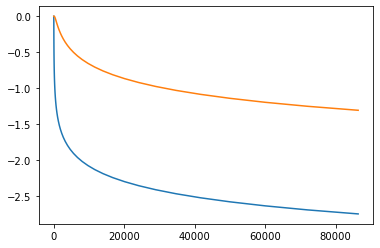

In [23]:
plt.plot(alltimes,hydrograph[0])
plt.plot(alltimes,hydrograph[1])

In [24]:
import theis_script2

In [25]:
dd_analytical = theis_script2.theis_analytical(alltimes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
1.3215506136570812
the end


In [27]:
if os.path.exists('tmp_images'):
    shutil.rmtree('tmp_images')
os.mkdir('tmp_images')
# make a temporary directory for the images.

In [29]:
with PdfPages('theis_modflow_analytical.pdf') as pdfout:
    for i in range(len(alltimes)):
        fig = plt.figure(figsize=(8,8))
        fig.add_subplot(121)
        plt.imshow(-head[i,0,490:510,490:510],
                  interpolation='nearest',
                  vmin = 0,
                  vmax = 1.7, cmap='magma')
        plt.title('MODFLOW')
        fig.add_subplot(122)
        plt.imshow(dd_analytical[i], interpolation='nearest',
                  vmin=0,
                  vmax=1.7, cmap='magma')
        plt.title('Analytical')
        plt.suptitle('Theis two ways: timestep = {0}'.format(i+1))
        plt.tight_layout()
        
        pdfout.savefig()
        
         # also make a png
        plt.savefig('tmp_images/{0}.png'.format(i))
        
        plt.close()

In [33]:
# make a gif
import imageio

gif_path = 'modflow_theis.gif'
frames_path = 'tmp_images/{i}.png'

with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(len(alltimes)):
        writer.append_data(imageio.imread(frames_path.format(i=i)))

In [34]:
# make a .mpeg
import imageio_ffmpeg

mp4_path = 'modflow_theis.mp4'
frames_path = 'tmp_images/{i}.png'

with imageio.get_writer(mp4_path, mode='I') as writer:
    for i in range(len(alltimes)):
        writer.append_data(imageio.imread(frames_path.format(i=i)))